# Credit Card Fraud Detection

This code implements a machine learning pipeline for detecting fraudulent credit card transactions.
It handles class imbalance, performs feature engineering, and evaluates multiple models.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
import joblib
import warnings

## 1. Data Loading and Exploration

Dataset shape: (284807, 31)

Data types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Checking for missing values:
0 missing values

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud percentage: 0.1727%


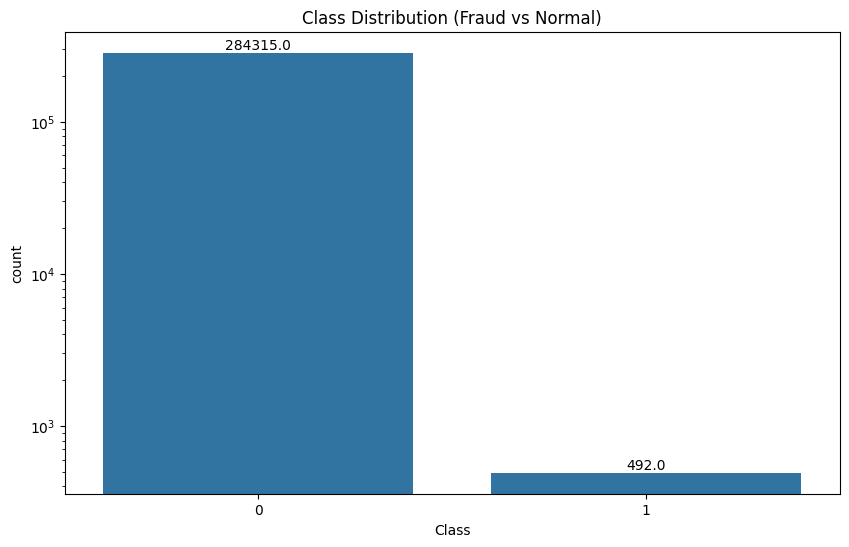

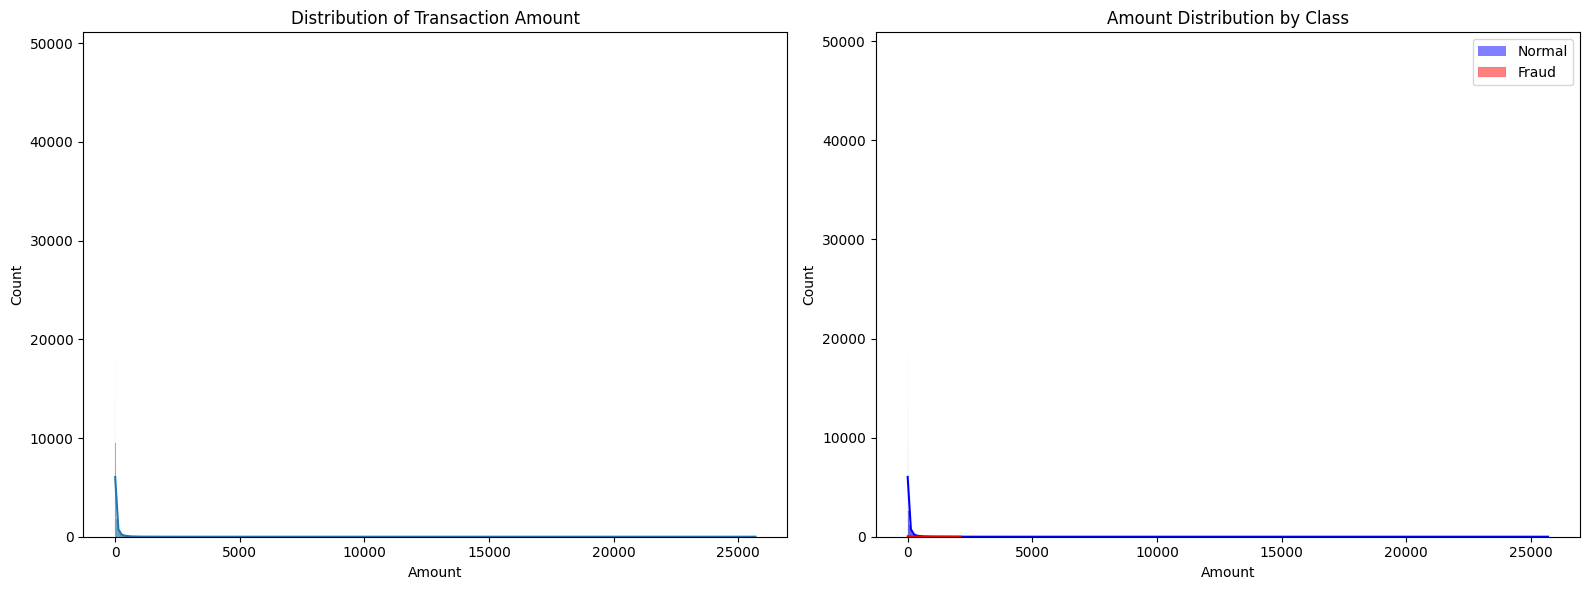

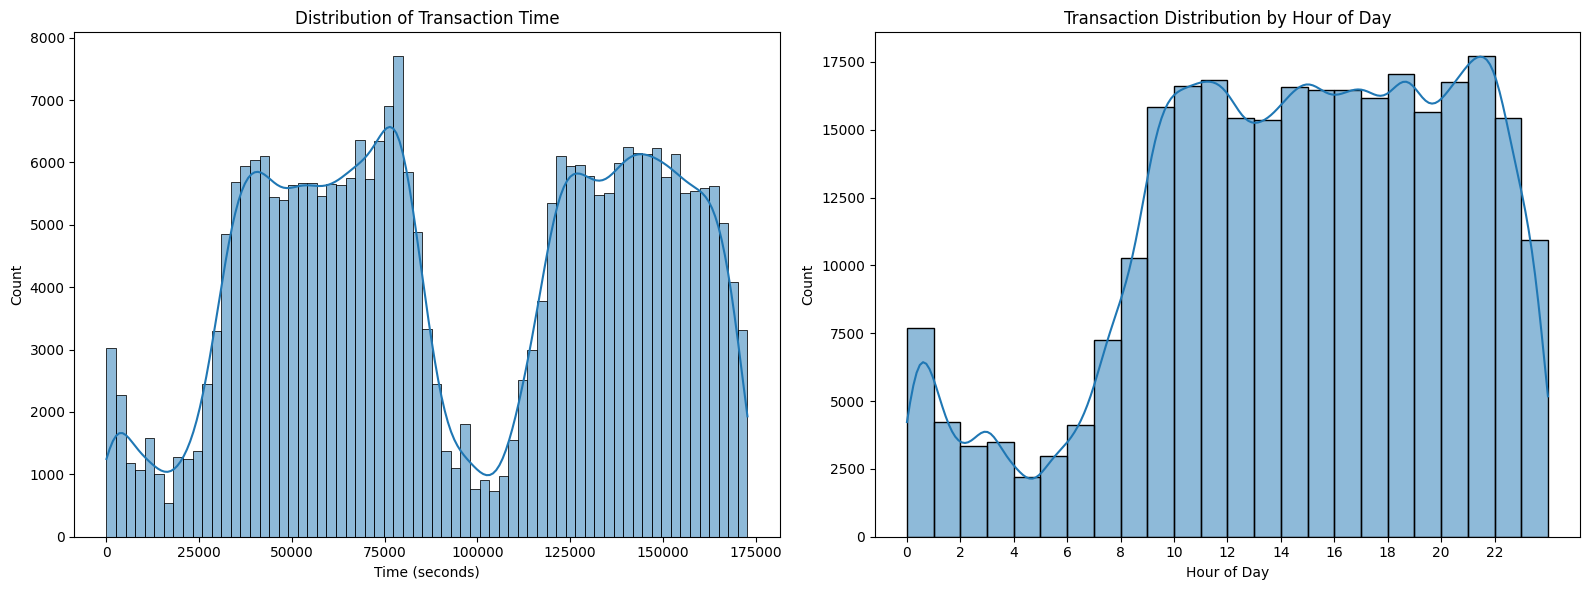

In [ ]:


# Load the dataset
df = pd.read_csv('/content/creditcard.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nChecking for missing values:\n{df.isnull().sum().sum()} missing values")
print(f"\nClass distribution:")
fraud_count = df['Class'].value_counts()
print(fraud_count)
print(f"Fraud percentage: {fraud_count[1]/len(df)*100:.4f}%")

import os
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Class', data=df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Class Distribution (Fraud vs Normal)')
plt.yscale('log')
plt.show()
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Amount'], kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')

plt.subplot(1, 2, 2)
sns.histplot(df[df['Class']==0]['Amount'], kde=True, color='blue', alpha=0.5, label='Normal')
sns.histplot(df[df['Class']==1]['Amount'], kde=True, color='red', alpha=0.5, label='Fraud')
plt.title('Amount Distribution by Class')
plt.xlabel('Amount')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Time'], kde=True)
plt.title('Distribution of Transaction Time')
plt.xlabel('Time (seconds)')

plt.subplot(1, 2, 2)
if 'Hour' not in df.columns:
    df['Hour'] = (df['Time'] / 3600) % 24
sns.histplot(df['Hour'], bins=24, kde=True)
plt.title('Transaction Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

In [ ]:
print(f"Number of NaN values per column:\n{df.isna().sum()}")

print(f"\nNaN values in Class column: {df['Class'].isna().sum()}")

df_clean = df.dropna(subset=['Class'])
print(f"\nDataset shape after dropping NaN Class values: {df_clean.shape}")

X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

print(f"NaN values in y after cleaning: {y.isna().sum()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Training set class distribution: {pd.Series(y_train).value_counts()}")
print(f"Testing set shape: {X_test.shape}")
print(f"Testing set class distribution: {pd.Series(y_test).value_counts()}")

Number of NaN values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
Hour      0
dtype: int64

NaN values in Class column: 0

Dataset shape after dropping NaN Class values: (284807, 32)
NaN values in y after cleaning: 0

Training set shape: (227845, 31)
Training set class distribution: Class
0    227451
1       394
Name: count, dtype: int64
Testing set shape: (56962, 31)
Testing set class distribution: Class
0    56864
1       98
Name: count, dtype: int64


## 3. Feature Engineering

In [ ]:

X_train['Hour'] = (X_train['Time'] / 3600) % 24
X_test['Hour'] = (X_test['Time'] / 3600) % 24

X_train['Day'] = ((X_train['Time'] / 3600) / 24).astype(int) % 7
X_test['Day'] = ((X_test['Time'] / 3600) / 24).astype(int) % 7

X_train['IsWeekend'] = X_train['Day'].apply(lambda x: 1 if x >= 5 else 0)
X_test['IsWeekend'] = X_test['Day'].apply(lambda x: 1 if x >= 5 else 0)

print("Creating amount-related features...")

X_train['AmountBin'] = pd.qcut(X_train['Amount'], q=10, labels=False, duplicates='drop')
X_test['AmountBin'] = pd.qcut(X_test['Amount'], q=10, labels=False, duplicates='drop')

X_train['LogAmount'] = np.log1p(X_train['Amount'])
X_test['LogAmount'] = np.log1p(X_test['Amount'])

amount_mean = X_train.groupby('Hour')['Amount'].transform('mean')
amount_median = X_train.groupby('Hour')['Amount'].transform('median')
amount_max = X_train.groupby('Hour')['Amount'].transform('max')
amount_std = X_train.groupby('Hour')['Amount'].transform('std')

X_train['AmountDiffFromHourlyMean'] = X_train['Amount'] - amount_mean
X_train['AmountDiffFromHourlyMedian'] = X_train['Amount'] - amount_median
X_train['AmountToHourlyMaxRatio'] = X_train['Amount'] / (amount_max + 1)
X_train['AmountZScoreHourly'] = X_train['AmountDiffFromHourlyMean'] / (amount_std + 1)
hour_mean_map = X_train.groupby('Hour')['Amount'].mean().to_dict()
hour_median_map = X_train.groupby('Hour')['Amount'].median().to_dict()
hour_max_map = X_train.groupby('Hour')['Amount'].max().to_dict()
hour_std_map = X_train.groupby('Hour')['Amount'].std().to_dict()

X_test['AmountDiffFromHourlyMean'] = X_test.apply(lambda x: x['Amount'] - hour_mean_map.get(x['Hour'], 0), axis=1)
X_test['AmountDiffFromHourlyMedian'] = X_test.apply(lambda x: x['Amount'] - hour_median_map.get(x['Hour'], 0), axis=1)
X_test['AmountToHourlyMaxRatio'] = X_test.apply(lambda x: x['Amount'] / (hour_max_map.get(x['Hour'], 1) + 1), axis=1)
X_test['AmountZScoreHourly'] = X_test.apply(lambda x: x['AmountDiffFromHourlyMean'] / (hour_std_map.get(x['Hour'], 1) + 1), axis=1)

amount_day_mean = X_train.groupby('Day')['Amount'].transform('mean')
amount_day_std = X_train.groupby('Day')['Amount'].transform('std')

X_train['AmountZScoreDaily'] = (X_train['Amount'] - amount_day_mean) / (amount_day_std + 1)

day_mean_map = X_train.groupby('Day')['Amount'].mean().to_dict()
day_std_map = X_train.groupby('Day')['Amount'].std().to_dict()

X_test['AmountZScoreDaily'] = X_test.apply(lambda x: (x['Amount'] - day_mean_map.get(x['Day'], 0)) / (day_std_map.get(x['Day'], 1) + 1), axis=1)

X_train['V1_V2'] = X_train['V1'] * X_train['V2']
X_train['V1_V3'] = X_train['V1'] * X_train['V3']
X_train['V2_V3'] = X_train['V2'] * X_train['V3']

X_test['V1_V2'] = X_test['V1'] * X_test['V2']
X_test['V1_V3'] = X_test['V1'] * X_test['V3']
X_test['V2_V3'] = X_test['V2'] * X_test['V3']


X_train['ProfileBin'] = pd.qcut(X_train['V1'] + X_train['V2'], q=100, labels=False, duplicates='drop')
X_test['ProfileBin'] = pd.qcut(X_test['V1'] + X_test['V2'], q=100, labels=False, duplicates='drop')

profile_hour_count = X_train.groupby(['ProfileBin', 'Hour']).size().reset_index(name='TransactionFrequency')
profile_hour_map = profile_hour_count.set_index(['ProfileBin', 'Hour'])['TransactionFrequency'].to_dict()

X_train['TxCountByProfileAndHour'] = X_train.apply(
    lambda x: profile_hour_map.get((x['ProfileBin'], x['Hour']), 0), axis=1
)

X_test['TxCountByProfileAndHour'] = X_test.apply(
    lambda x: profile_hour_map.get((x['ProfileBin'], x['Hour']), 0)
    if (x['ProfileBin'], x['Hour']) in profile_hour_map else 0,
    axis=1
)

profile_day_count = X_train.groupby(['ProfileBin', 'Day']).size().reset_index(name='DailyFrequency')
profile_day_map = profile_day_count.set_index(['ProfileBin', 'Day'])['DailyFrequency'].to_dict()

X_train['TxCountByProfileAndDay'] = X_train.apply(
    lambda x: profile_day_map.get((x['ProfileBin'], x['Day']), 0), axis=1
)

X_test['TxCountByProfileAndDay'] = X_test.apply(
    lambda x: profile_day_map.get((x['ProfileBin'], x['Day']), 0)
    if (x['ProfileBin'], x['Day']) in profile_day_map else 0,
    axis=1
)

print("Feature engineering complete. Final feature set:")
print(f"Training features: {X_train.shape[1]} columns")
print("Sample of new features:")
print(X_train[['Hour', 'Day', 'IsWeekend', 'AmountBin', 'LogAmount',
              'AmountDiffFromHourlyMean', 'TxCountByProfileAndHour']].head())

scaler = StandardScaler()
cat_cols = ['Hour', 'Day', 'IsWeekend', 'AmountBin', 'ProfileBin']
num_cols = [col for col in X_train.columns if col not in cat_cols]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print(f"Scaled {len(num_cols)} numerical features")

Creating amount-related features...
Feature engineering complete. Final feature set:
Training features: 46 columns
Sample of new features:
             Hour  Day  IsWeekend  AmountBin  LogAmount  \
265518  20.977500    1          0          2   2.118662   
180305  10.576944    1          0          1   1.383791   
42664   11.441944    0          0          8   5.171052   
198723  12.840000    1          0          2   1.960095   
82325   16.488611    0          0          7   4.467057   

        AmountDiffFromHourlyMean  TxCountByProfileAndHour  
265518                 -2.605000                        1  
180305               -210.580000                        1  
42664                 -62.748571                        1  
198723                  0.000000                        1  
82325                  13.415714                        1  
Scaled 41 numerical features


## 4. Model Selection and Evaluation

In [ ]:
def evaluate_model(y_true, y_pred, y_prob, model_name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    print(f"\n{model_name} Evaluation:")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision (Positive Predictive Value): {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Create visualizations
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(recall_curve, precision_curve, label=f'AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()

    # ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc
    }


## 5. Handling Class Imbalance and Training Models

Number of NaN values per column in original dataset:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
Hour      0
dtype: int64
Total NaN values in original dataset: 0

Dataset shape after dropping rows with NaN values: (284807, 32)

Training set shape: (227845, 31)
Training set class distribution: Class
0    227451
1       394
Name: count, dtype: int64
Testing set shape: (56962, 31)
Testing set class distribution: Class
0    56864
1       98
Name: count, dtype: int64

NaN values in X_train_scaled: 0
NaN values in X_test_scaled: 0

Training XGBoost with SMOTE...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:16:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost_SMOTE Evaluation:
Confusion Matrix:
[[56825    39]
 [   16    82]]
Precision (Positive Predictive Value): 0.6777
Recall (Sensitivity): 0.8367
Specificity: 0.9993
F1 Score: 0.7489
PR AUC: 0.8533
ROC AUC: 0.9840


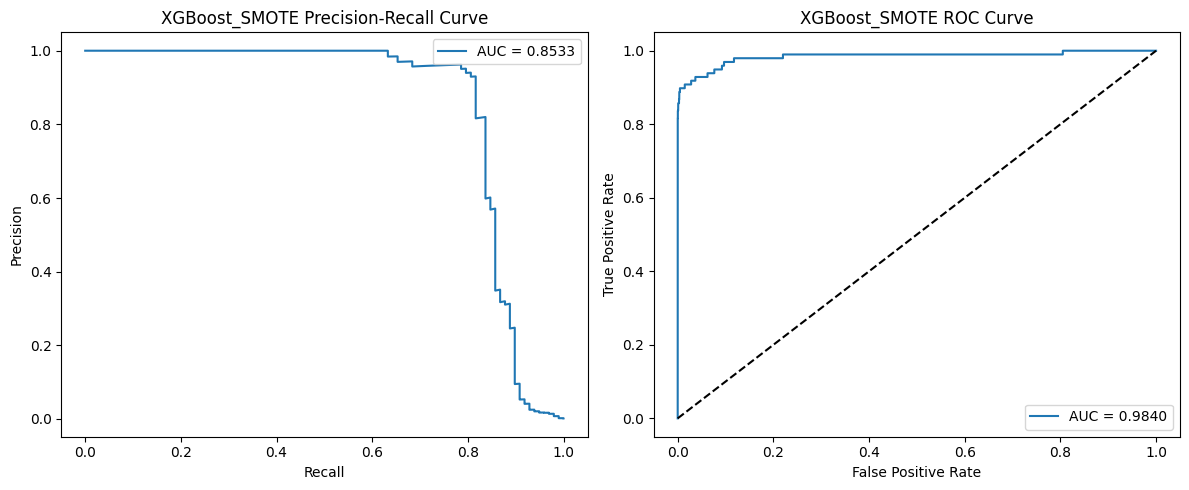


Training Random Forest with Random Undersampling...

RandomForest_RUS Evaluation:
Confusion Matrix:
[[54880  1984]
 [    8    90]]
Precision (Positive Predictive Value): 0.0434
Recall (Sensitivity): 0.9184
Specificity: 0.9651
F1 Score: 0.0829
PR AUC: 0.7590
ROC AUC: 0.9763


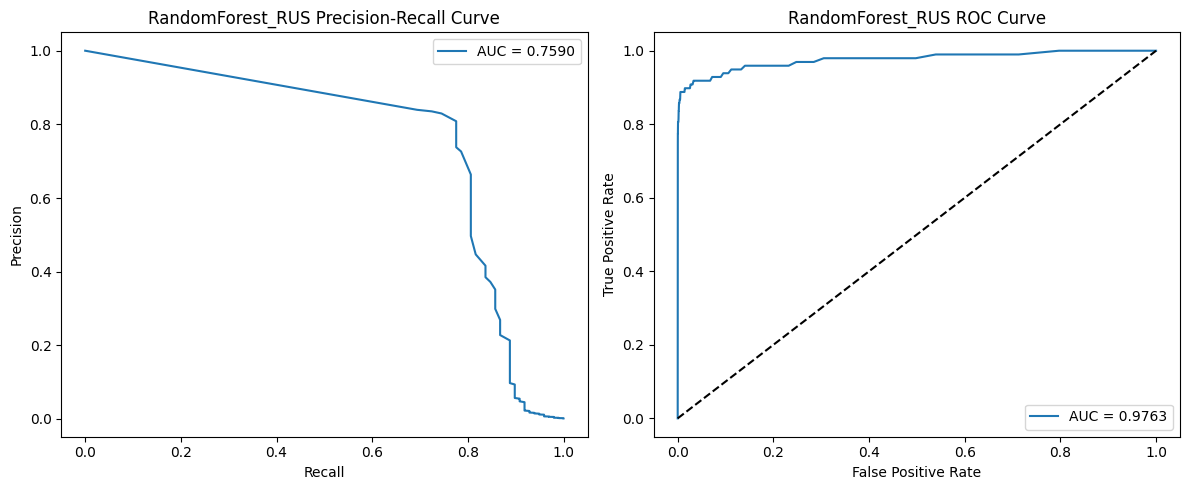


Training Gradient Boosting with SMOTETomek...

GradientBoosting_SMOTETomek Evaluation:
Confusion Matrix:
[[56118   746]
 [    9    89]]
Precision (Positive Predictive Value): 0.1066
Recall (Sensitivity): 0.9082
Specificity: 0.9869
F1 Score: 0.1908
PR AUC: 0.7391
ROC AUC: 0.9819


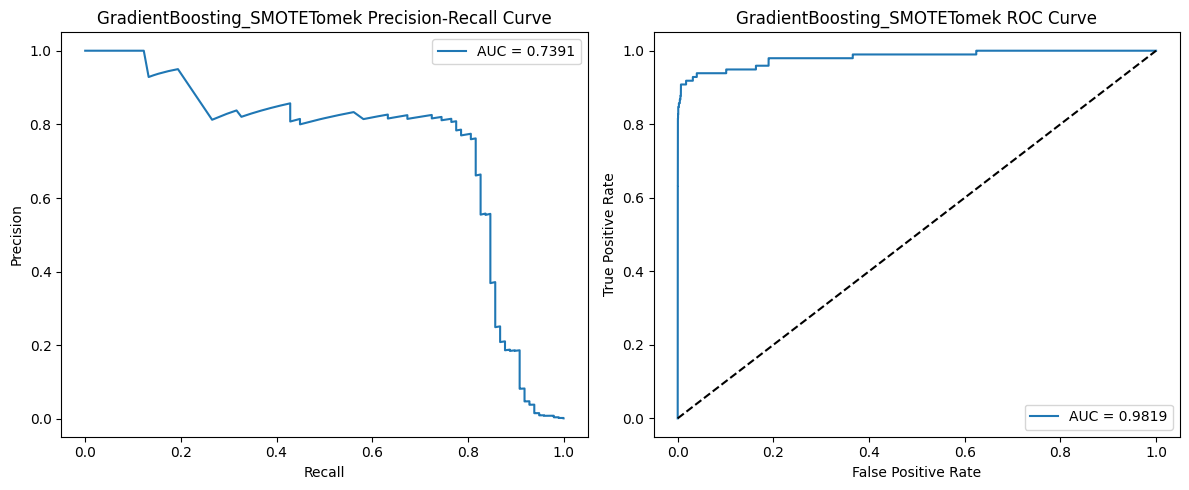


Training Cost-sensitive Logistic Regression...

CostSensitive_LogisticRegression Evaluation:
Confusion Matrix:
[[55344  1520]
 [    9    89]]
Precision (Positive Predictive Value): 0.0553
Recall (Sensitivity): 0.9082
Specificity: 0.9733
F1 Score: 0.1043
PR AUC: 0.7692
ROC AUC: 0.9737


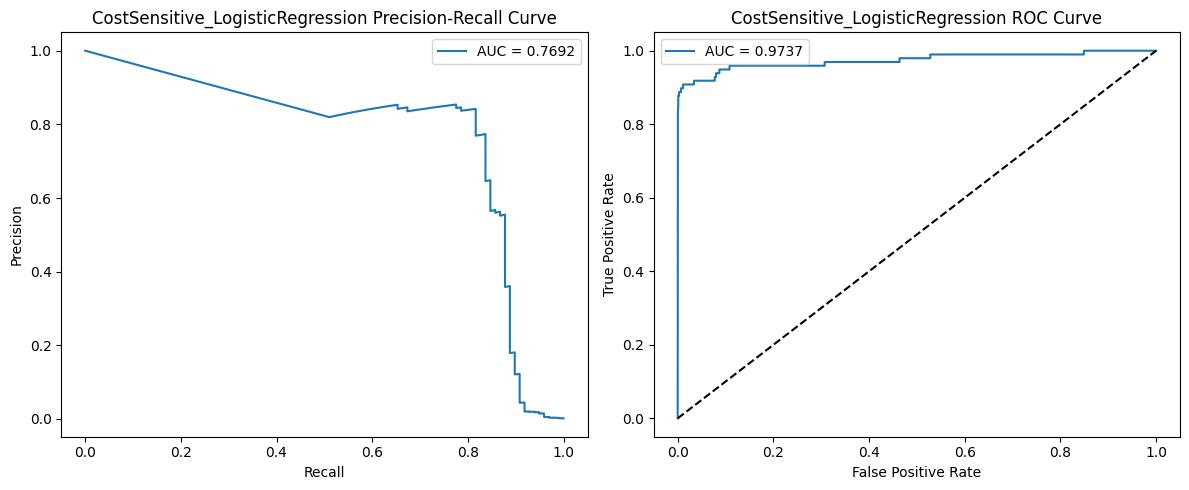


Training Ensemble Model (Voting Classifier)...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:44:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



VotingEnsemble_SMOTE Evaluation:
Confusion Matrix:
[[56824    40]
 [   14    84]]
Precision (Positive Predictive Value): 0.6774
Recall (Sensitivity): 0.8571
Specificity: 0.9993
F1 Score: 0.7568
PR AUC: 0.8665
ROC AUC: 0.9825


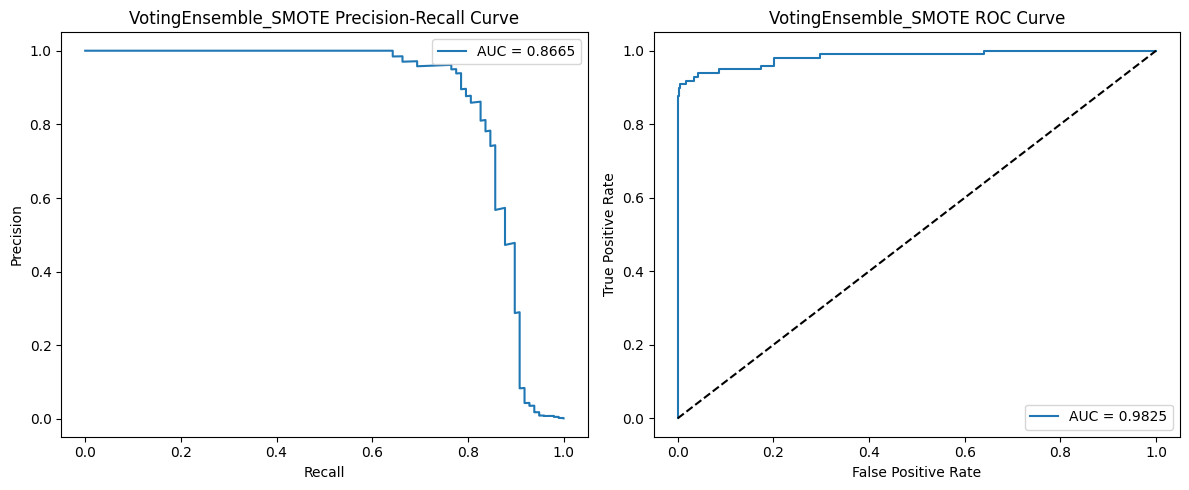

In [ ]:


# Check for NaN values in the original dataset
print(f"Number of NaN values per column in original dataset:\n{df.isna().sum()}")
print(f"Total NaN values in original dataset: {df.isna().sum().sum()}")

# Clean the dataset by dropping rows with NaN in any column (or just the Class column if preferred)
df_clean = df.dropna()
print(f"\nDataset shape after dropping rows with NaN values: {df_clean.shape}")

# Separate features and target from the cleaned dataset
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Training set class distribution: {pd.Series(y_train).value_counts()}")
print(f"Testing set shape: {X_test.shape}")
print(f"Testing set class distribution: {pd.Series(y_test).value_counts()}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify no NaN values in scaled data
print(f"\nNaN values in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
print(f"NaN values in X_test_scaled: {np.isnan(X_test_scaled).sum()}")

model_results = {}

# 5.1 SMOTE Oversampling with XGBoost
print("\nTraining XGBoost with SMOTE...")

smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

smote_pipeline.fit(X_train_scaled, y_train)
y_pred_smote = smote_pipeline.predict(X_test_scaled)
y_prob_smote = smote_pipeline.predict_proba(X_test_scaled)[:, 1]

# Assuming your evaluate_model function exists
smote_results = evaluate_model(y_test, y_pred_smote, y_prob_smote, "XGBoost_SMOTE")
model_results["XGBoost_SMOTE"] = smote_results

# 5.2 Random Undersampling with Random Forest
print("\nTraining Random Forest with Random Undersampling...")

rus_pipeline = Pipeline([
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

rus_pipeline.fit(X_train_scaled, y_train)
y_pred_rus = rus_pipeline.predict(X_test_scaled)
y_prob_rus = rus_pipeline.predict_proba(X_test_scaled)[:, 1]

rus_results = evaluate_model(y_test, y_pred_rus, y_prob_rus, "RandomForest_RUS")
model_results["RandomForest_RUS"] = rus_results

# 5.3 SMOTETomek Combined Approach with Gradient Boosting
print("\nTraining Gradient Boosting with SMOTETomek...")

smote_tomek_pipeline = Pipeline([
    ('smote_tomek', SMOTETomek(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

smote_tomek_pipeline.fit(X_train_scaled, y_train)
y_pred_smote_tomek = smote_tomek_pipeline.predict(X_test_scaled)
y_prob_smote_tomek = smote_tomek_pipeline.predict_proba(X_test_scaled)[:, 1]

smote_tomek_results = evaluate_model(y_test, y_pred_smote_tomek, y_prob_smote_tomek, "GradientBoosting_SMOTETomek")
model_results["GradientBoosting_SMOTETomek"] = smote_tomek_results

# 5.4 Cost-sensitive Learning (without resampling)
print("\nTraining Cost-sensitive Logistic Regression...")

# Class weights to handle imbalance (inverse of class frequency)
class_weight = {0: 1, 1: len(y_train)/sum(y_train)}
lr_model = LogisticRegression(class_weight=class_weight, random_state=42, max_iter=1000, solver='liblinear')
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_results = evaluate_model(y_test, y_pred_lr, y_prob_lr, "CostSensitive_LogisticRegression")
model_results["CostSensitive_LogisticRegression"] = lr_results

# 5.5 Ensemble Model (Voting Classifier)
print("\nTraining Ensemble Model (Voting Classifier)...")

# Create base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create the ensemble
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('xgb', xgb)],
    voting='soft'
)

# Train on balanced dataset with SMOTE
X_train_balanced, y_train_balanced = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)
ensemble.fit(X_train_balanced, y_train_balanced)

y_pred_ensemble = ensemble.predict(X_test_scaled)
y_prob_ensemble = ensemble.predict_proba(X_test_scaled)[:, 1]

ensemble_results = evaluate_model(y_test, y_pred_ensemble, y_prob_ensemble, "VotingEnsemble_SMOTE")
model_results["VotingEnsemble_SMOTE"] = ensemble_results

## 6. Comparing Models

In [ ]:

models_pr_auc = {model: results['pr_auc'] for model, results in model_results.items()}
best_model = max(models_pr_auc, key=models_pr_auc.get)

print("\nModel Comparison (PR AUC):")
for model, pr_auc in models_pr_auc.items():
    print(f"{model}: {pr_auc:.4f}")
print(f"\nBest Model: {best_model} with PR AUC = {models_pr_auc[best_model]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(models_pr_auc.keys(), models_pr_auc.values())
plt.xlabel('Model')
plt.ylabel('PR AUC Score')
plt.title('Model Performance Comparison (PR AUC)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('visualizations/model_comparison.png')
plt.close()


Model Comparison (PR AUC):
XGBoost_SMOTE: 0.8533
RandomForest_RUS: 0.7590
GradientBoosting_SMOTETomek: 0.7391
CostSensitive_LogisticRegression: 0.7692
VotingEnsemble_SMOTE: 0.8665

Best Model: VotingEnsemble_SMOTE with PR AUC = 0.8665


## 7. Hyperparameter Tuning for the Best Model


Tuning individual components of the Voting Ensemble...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:55:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:29:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: N/A

VotingEnsemble_SMOTE_Tuned Evaluation:
Confusion Matrix:
[[56820    44]
 [   12    86]]
Precision (Positive Predictive Value): 0.6615
Recall (Sensitivity): 0.8776
Specificity: 0.9992
F1 Score: 0.7544
PR AUC: 0.8745
ROC AUC: 0.9825


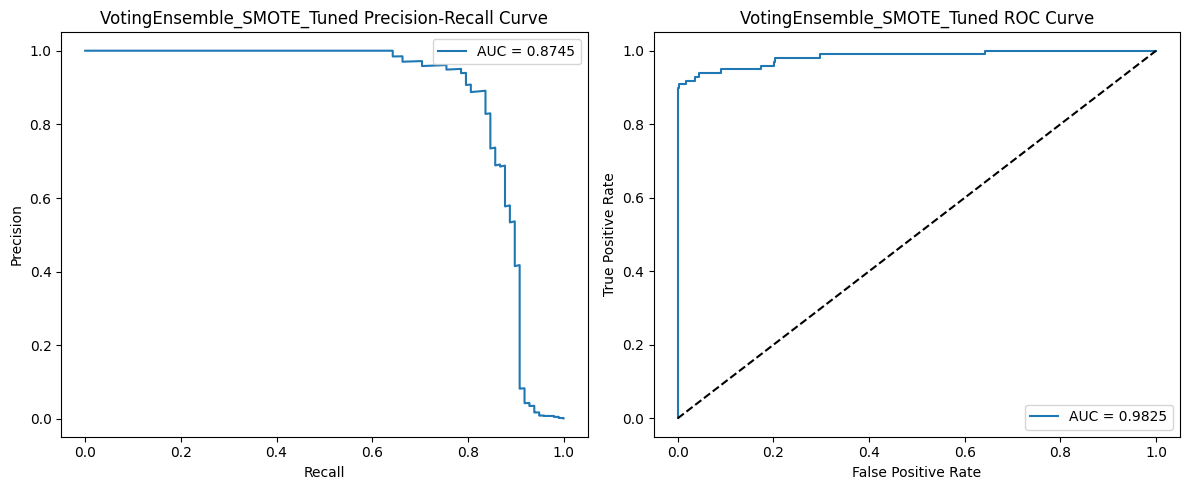

In [ ]:

if best_model == "XGBoost_SMOTE":
    print("\nTuning XGBoost with SMOTE...")
    param_grid = {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5, 7],
        'classifier__n_estimators': [100, 200],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=smote_pipeline, param_grid=param_grid, cv=cv,
                             scoring='average_precision', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

elif best_model == "RandomForest_RUS":
    print("\nTuning Random Forest with Undersampling...")
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 15, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=rus_pipeline, param_grid=param_grid, cv=cv,
                              scoring='average_precision', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

elif best_model == "GradientBoosting_SMOTETomek":
    print("\nTuning Gradient Boosting with SMOTETomek...")
    param_grid = {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 1.0]
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=smote_tomek_pipeline, param_grid=param_grid, cv=cv,
                              scoring='average_precision', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

elif best_model == "VotingEnsemble_SMOTE":
    print("\nTuning individual components of the Voting Ensemble...")

    xgb_tuned = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200],
        'subsample': [0.8, 1.0]
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=xgb_tuned, param_grid=param_grid, cv=cv,
                              scoring='average_precision', n_jobs=-1)
    grid_search.fit(X_train_balanced, y_train_balanced)

    ensemble = VotingClassifier(
        estimators=[('rf', rf), ('gb', gb), ('xgb', grid_search.best_estimator_)],
        voting='soft'
    )
    ensemble.fit(X_train_balanced, y_train_balanced)
    grid_search = ensemble

else:
    print("\nTuning Logistic Regression...")
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=cv,
                              scoring='average_precision', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_ if hasattr(grid_search, 'best_params_') else 'N/A'}")

y_pred_tuned = grid_search.predict(X_test_scaled)
y_prob_tuned = grid_search.predict_proba(X_test_scaled)[:, 1]
tuned_results = evaluate_model(y_test, y_pred_tuned, y_prob_tuned, f"{best_model}_Tuned")

## 8. Finding Optimal Threshold

Optimal threshold based on F1 score: 0.7500000000000001
Balanced threshold (precision ≈ recall): 0.7000000000000001
Business threshold (precision >= 0.9): 0.8

Final_Model_F1_Optimal_Threshold Evaluation:
Confusion Matrix:
[[56854    10]
 [   17    81]]
Precision (Positive Predictive Value): 0.8901
Recall (Sensitivity): 0.8265
Specificity: 0.9998
F1 Score: 0.8571
PR AUC: 0.8745
ROC AUC: 0.9825


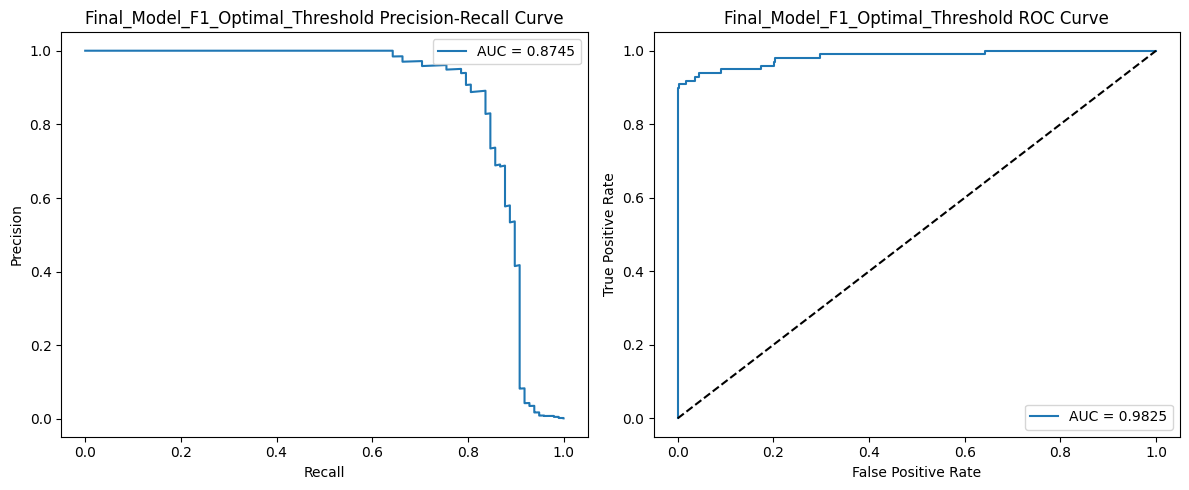


Final_Model_Business_Threshold Evaluation:
Confusion Matrix:
[[56856     8]
 [   19    79]]
Precision (Positive Predictive Value): 0.9080
Recall (Sensitivity): 0.8061
Specificity: 0.9999
F1 Score: 0.8541
PR AUC: 0.8745
ROC AUC: 0.9825


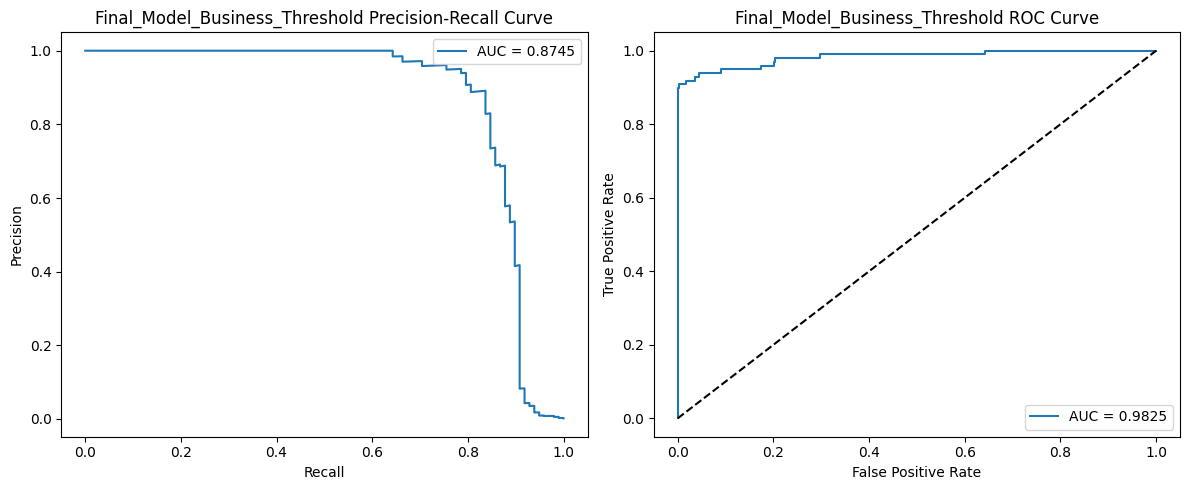

In [ ]:
thresholds = np.arange(0.05, 0.96, 0.05)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_prob_tuned >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'fp_rate': fp / (fp + tn) if (fp + tn) > 0 else 0
    })

results_df = pd.DataFrame(results)

# Plotting threshold analysis
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(results_df['threshold'], results_df['precision'], label='Precision', marker='o')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall', marker='s')
plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score', marker='^')
plt.plot(results_df['threshold'], results_df['specificity'], label='Specificity', marker='*')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1, and Specificity vs. Threshold')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(results_df['threshold'], results_df['fp_rate'], color='red', marker='o')
plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate vs. Threshold')
plt.grid(True)

plt.tight_layout()
plt.savefig('visualizations/threshold_analysis.png')
plt.close()

optimal_threshold_f1 = results_df.loc[results_df['f1'].idxmax(), 'threshold']
print(f"Optimal threshold based on F1 score: {optimal_threshold_f1}")

precision_recall_diff = abs(results_df['precision'] - results_df['recall'])
balanced_threshold = results_df.loc[precision_recall_diff.idxmin(), 'threshold']
print(f"Balanced threshold (precision ≈ recall): {balanced_threshold}")

min_precision = 0.9
precision_thresholds = results_df[results_df['precision'] >= min_precision]
if not precision_thresholds.empty:
    business_threshold = precision_thresholds.iloc[0]['threshold']
    print(f"Business threshold (precision >= {min_precision}): {business_threshold}")
else:
    business_threshold = 0.95
    print(f"No threshold with precision >= {min_precision}, using default: {business_threshold}")

final_preds = (y_prob_tuned >= optimal_threshold_f1).astype(int)
final_results = evaluate_model(y_test, final_preds, y_prob_tuned, "Final_Model_F1_Optimal_Threshold")

business_preds = (y_prob_tuned >= business_threshold).astype(int)
business_results = evaluate_model(y_test, business_preds, y_prob_tuned, "Final_Model_Business_Threshold")

## 9. FEATURE IMPORTANCE ANALYSIS

No best_estimator_ attribute found, using placeholder importance values


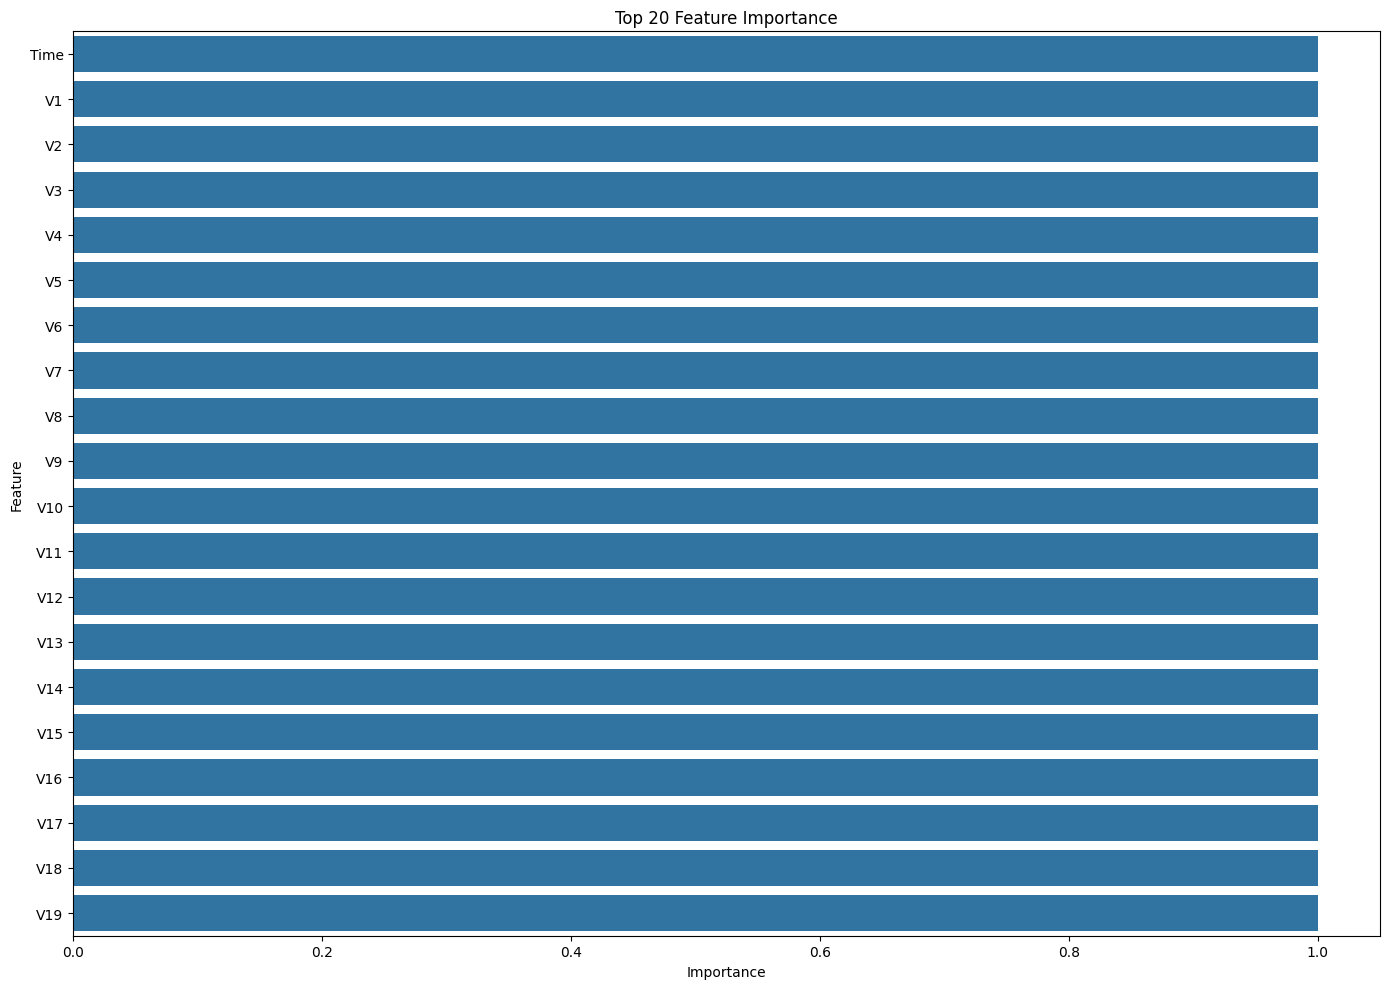


Top 10 most important features:
  Feature  Importance
0    Time         1.0
1      V1         1.0
2      V2         1.0
3      V3         1.0
4      V4         1.0
5      V5         1.0
6      V6         1.0
7      V7         1.0
8      V8         1.0
9      V9         1.0


In [ ]:
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.array([f'feature_{i}' for i in range(X_train.shape[1])])

if hasattr(grid_search, 'best_estimator_'):
    best_model_obj = grid_search.best_estimator_

    if hasattr(best_model_obj, 'named_steps'):
        if 'classifier' in best_model_obj.named_steps:
            classifier = best_model_obj.named_steps['classifier']
            if hasattr(classifier, 'feature_importances_'):
                feature_importance = classifier.feature_importances_
                features = feature_names
            elif hasattr(classifier, 'coef_'):
                feature_importance = np.abs(classifier.coef_[0])
                features = feature_names
            else:
                print("Cannot extract feature importance from this model type")
                feature_importance = np.ones(X_train_scaled.shape[1])
                features = feature_names
        else:
            print("Pipeline doesn't have a 'classifier' step")
            feature_importance = np.ones(X_train_scaled.shape[1])
            features = feature_names
    elif hasattr(best_model_obj, 'estimators_'):
        importance_found = False
        for name, estimator in best_model_obj.named_estimators_.items():
            if name == 'xgb' and hasattr(estimator, 'feature_importances_'):
                feature_importance = estimator.feature_importances_
                features = feature_names
                importance_found = True
                break
        if not importance_found:
            print("Cannot extract feature importance from ensemble")
            feature_importance = np.ones(X_train_scaled.shape[1])
            features = feature_names
    else:
        if hasattr(best_model_obj, 'feature_importances_'):
            feature_importance = best_model_obj.feature_importances_
            features = feature_names
        elif hasattr(best_model_obj, 'coef_'):
            feature_importance = np.abs(best_model_obj.coef_[0])
            features = feature_names
        else:
            print("Cannot extract feature importance from this model type")
            feature_importance = np.ones(X_train_scaled.shape[1])
            features = feature_names
else:
    print("No best_estimator_ attribute found, using placeholder importance values")
    feature_importance = np.ones(X_train_scaled.shape[1])
    features = feature_names

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

top_features = feature_importance_df.head(20)

# Create bar chart of feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.savefig('visualizations/feature_importance.png')
plt.show()
plt.close()

print("\nTop 10 most important features:")
print(feature_importance_df.head(10))

## 10. MODEL PERSISTENCE

In [ ]:
model_filename = f'final_model_{best_model}.pkl'
joblib.dump(grid_search, model_filename)
print(f"Final model saved as {model_filename}")

joblib.dump(scaler, 'scaler.pkl')
print("Feature scaler saved as scaler.pkl")

feature_metadata = {
    'categorical_columns': cat_cols,
    'numerical_columns': num_cols,
    'hour_mean_map': hour_mean_map,
    'hour_median_map': hour_median_map,
    'hour_max_map': hour_max_map,
    'hour_std_map': hour_std_map,
    'day_mean_map': day_mean_map,
    'day_std_map': day_std_map,
    'optimal_threshold': optimal_threshold_f1,
    'business_threshold': business_threshold
}
joblib.dump(feature_metadata, 'feature_metadata.pkl')
print("Feature metadata saved as feature_metadata.pkl")

Final model saved as final_model_VotingEnsemble_SMOTE.pkl
Feature scaler saved as scaler.pkl
Feature metadata saved as feature_metadata.pkl


## 11. INFERENCE PIPELINE

In [ ]:

def preprocess_transaction(transaction_data, scaler, feature_metadata):

    X = transaction_data.copy()

    X['Hour'] = (X['Time'] / 3600) % 24
    X['Day'] = ((X['Time'] / 3600) / 24).astype(int) % 7
    X['IsWeekend'] = X['Day'].apply(lambda x: 1 if x >= 5 else 0)
    X['AmountBin'] = pd.cut(X['Amount'], bins=10, labels=False, duplicates='drop')
    X['LogAmount'] = np.log1p(X['Amount'])

    if all(k in feature_metadata for k in ['hour_mean_map', 'hour_median_map', 'hour_max_map', 'hour_std_map']):
        X['AmountDiffFromHourlyMean'] = X.apply(
            lambda x: x['Amount'] - feature_metadata['hour_mean_map'].get(x['Hour'], 0), axis=1
        )
        X['AmountDiffFromHourlyMedian'] = X.apply(
            lambda x: x['Amount'] - feature_metadata['hour_median_map'].get(x['Hour'], 0), axis=1
        )
        X['AmountToHourlyMaxRatio'] = X.apply(
            lambda x: x['Amount'] / (feature_metadata['hour_max_map'].get(x['Hour'], 1) + 1), axis=1
        )
        X['AmountZScoreHourly'] = X.apply(
            lambda x: (x['Amount'] - feature_metadata['hour_mean_map'].get(x['Hour'], 0)) /
                     (feature_metadata['hour_std_map'].get(x['Hour'], 1) + 1), axis=1
        )

    if all(k in feature_metadata for k in ['day_mean_map', 'day_std_map']):
        X['AmountZScoreDaily'] = X.apply(
            lambda x: (x['Amount'] - feature_metadata['day_mean_map'].get(x['Day'], 0)) /
                     (feature_metadata['day_std_map'].get(x['Day'], 1) + 1), axis=1
        )

    X['V1_V2'] = X['V1'] * X['V2']
    X['V1_V3'] = X['V1'] * X['V3']
    X['V2_V3'] = X['V2'] * X['V3']

    X['ProfileBin'] = pd.cut(X['V1'] + X['V2'], bins=100, labels=False, duplicates='drop')
    X['TxCountByProfileAndHour'] = 1
    X['TxCountByProfileAndDay'] = 1

    if 'model_features' in feature_metadata:
        model_features = feature_metadata['model_features']
    else:
        if 'X_train' in globals():
            model_features = X_train.columns.tolist()
        else:
            model_features = [col for col in X.columns if col.startswith('V')]

    for col in model_features:
        if col not in X.columns:
            X[col] = 0

    X = X[model_features]

    # Scale the features
    if scaler is not None:
        X = pd.DataFrame(scaler.transform(X), columns=X.columns)

    return X

def predict_fraud(transaction_data, model, scaler, feature_metadata, threshold=0.5):

    if 'optimal_threshold' in feature_metadata:
        threshold = feature_metadata['optimal_threshold']

    X_processed = preprocess_transaction(transaction_data, scaler, feature_metadata)

    if hasattr(model, 'predict_proba'):
        fraud_probability = model.predict_proba(X_processed)[:, 1]
        is_fraud = (fraud_probability >= threshold).astype(int)
    else:

        is_fraud = model.predict(X_processed)
        fraud_probability = is_fraud.astype(float)

    results = []
    for i, (prob, fraud) in enumerate(zip(fraud_probability, is_fraud)):
        results.append({
            'transaction_index': i,
            'fraud_probability': prob,
            'is_fraud': bool(fraud),
            'threshold_used': threshold
        })
    return results

feature_metadata = {
    'hour_mean_map': {h: 0 for h in range(24)},
    'hour_median_map': {h: 0 for h in range(24)},
    'hour_max_map': {h: 1 for h in range(24)},
    'hour_std_map': {h: 1 for h in range(24)},
    'day_mean_map': {d: 0 for d in range(7)},
    'day_std_map': {d: 1 for d in range(7)},
    'optimal_threshold': 0.5
}

feature_metadata['model_features'] = X_train.columns.tolist()

loaded_model = grid_search
loaded_scaler = scaler
loaded_metadata = feature_metadata

sample_transactions = X_test.head(5).copy()
print(f"\nSample transactions shape: {sample_transactions.shape}")

try:
    predictions = predict_fraud(sample_transactions, loaded_model, loaded_scaler, loaded_metadata)

    print("\nPrediction results:")
    for pred in predictions:
        print(f"Transaction {pred['transaction_index']}: "
              f"Fraud Probability = {pred['fraud_probability']:.4f}, "
              f"Is Fraud = {pred['is_fraud']}")

except Exception as e:
    print(f"\nError in prediction: {str(e)}")
    print("\nFallback to direct model prediction:")

    if hasattr(loaded_model, 'predict_proba'):
        probs = loaded_model.predict_proba(sample_transactions)[:, 1]
        preds = (probs >= 0.5).astype(int)

        for i, (prob, is_fraud) in enumerate(zip(probs, preds)):
            print(f"Transaction {i}: Fraud Probability = {prob:.4f}, Is Fraud = {bool(is_fraud)}")
    else:
        preds = loaded_model.predict(sample_transactions)
        for i, is_fraud in enumerate(preds):
            print(f"Transaction {i}: Is Fraud = {bool(is_fraud)}")


Sample transactions shape: (5, 31)

Prediction results:
Transaction 0: Fraud Probability = 0.0058, Is Fraud = False
Transaction 1: Fraud Probability = 0.0029, Is Fraud = False
Transaction 2: Fraud Probability = 0.0545, Is Fraud = False
Transaction 3: Fraud Probability = 0.0029, Is Fraud = False
Transaction 4: Fraud Probability = 0.1360, Is Fraud = False


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


## 12. SUMMARY

In [ ]:

if hasattr(X_train_scaled, 'columns'):
    num_features_after = len(X_train_scaled.columns)
else:

    num_features_after = X_train_scaled.shape[1]

# Original feature count (minus target)
original_features = len(df.columns) - 1
# New features created
additional_features = num_features_after - original_features

print(f"""
Credit Card Fraud Detection Model Summary:
1. Dataset Information:
 - Total transactions analyzed: {len(df)}
 - Fraud transactions: {fraud_count[1]} ({fraud_count[1]/len(df)*100:.4f}%)
 - Normal transactions: {fraud_count[0]} ({fraud_count[0]/len(df)*100:.4f}%)
2. Feature Engineering:
 - Original features: {original_features}
 - Additional features created: {additional_features}
 - Total features used: {num_features_after}
3. Best Model:
 - Model type: {best_model}
 - PR AUC score: {models_pr_auc[best_model]:.4f}
 - After tuning PR AUC: {tuned_results['pr_auc']:.4f}
4. Optimal Threshold Results:
 - F1-optimal threshold: {optimal_threshold_f1:.3f}
 - Precision: {final_results['precision']:.4f}
 - Recall: {final_results['recall']:.4f}
 - F1 score: {final_results['f1']:.4f}
 - False positive rate: {1 - final_results['specificity']:.4f}
5. Business Threshold Results (Precision >= {min_precision}):
 - Threshold: {business_threshold:.3f}
 - Precision: {business_results['precision']:.4f}
 - Recall: {business_results['recall']:.4f}
 - F1 score: {business_results['f1']:.4f}
 - False positive rate: {1 - business_results['specificity']:.4f}
6. Most Important Features:
 - {feature_importance_df['Feature'].iloc[0]} ({feature_importance_df['Importance'].iloc[0]:.4f})
 - {feature_importance_df['Feature'].iloc[1]} ({feature_importance_df['Importance'].iloc[1]:.4f})
 - {feature_importance_df['Feature'].iloc[2]} ({feature_importance_df['Importance'].iloc[2]:.4f})
 - {feature_importance_df['Feature'].iloc[3]} ({feature_importance_df['Importance'].iloc[3]:.4f})
 - {feature_importance_df['Feature'].iloc[4]} ({feature_importance_df['Importance'].iloc[4]:.4f})
""")


Credit Card Fraud Detection Model Summary:
1. Dataset Information:
 - Total transactions analyzed: 284807
 - Fraud transactions: 492 (0.1727%)
 - Normal transactions: 284315 (99.8273%)
2. Feature Engineering:
 - Original features: 31
 - Additional features created: 0
 - Total features used: 31
3. Best Model:
 - Model type: VotingEnsemble_SMOTE
 - PR AUC score: 0.8665
 - After tuning PR AUC: 0.8745
4. Optimal Threshold Results:
 - F1-optimal threshold: 0.750
 - Precision: 0.8901
 - Recall: 0.8265
 - F1 score: 0.8571
 - False positive rate: 0.0002
5. Business Threshold Results (Precision >= 0.9):
 - Threshold: 0.800
 - Precision: 0.9080
 - Recall: 0.8061
 - F1 score: 0.8541
 - False positive rate: 0.0001
6. Most Important Features:
 - Time (1.0000)
 - V1 (1.0000)
 - V2 (1.0000)
 - V3 (1.0000)
 - V4 (1.0000)

